In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, BatchNormalization,
                                     Activation, Dropout, Flatten, Dense)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# ----------------------------
# 1. Model Architecture: ScriptNet
# ----------------------------
def build_scriptnet(input_shape=(32, 32, 1), num_classes=83):
    inputs = Input(shape=input_shape, name='input_layer')

    # Block 1
    x = Conv2D(64, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same')(x)  # Extra convolution layer
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)  # Slightly increased dropout

    # Block 2
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same')(x)  # Extra convolution layer
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)

    # Block 3
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same')(x)  # Extra convolution layer
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.4)(x)

    # Fully connected layers
    x = Flatten()(x)
    x = Dense(1024)(x)  # Increased size
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    outputs = Dense(num_classes, activation='softmax', name='output_layer')(x)

    model = Model(inputs=inputs, outputs=outputs, name='ScriptNetEnhanced')
    return model

2025-05-28 19:04:50.110103: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748459090.295909      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748459090.354400      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# ----------------------------
# 2. Data Loading: BanglaLekha-Isolated
# ----------------------------
# Replace this with your full Google Drive path if needed
dataset_path = "/kaggle/input/bangla-lekha-isolated-dataset/BanglaLekha-Isolated/Images/"

input_shape = (32, 32, 1)
batch_size = 64
epochs = 30
num_classes = 84  # Update if using fewer classes

# ImageDataGenerator with augmentation for training and only rescaling for validation
datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    validation_split=0.2,

    #Augmentation settings for handwritten characters
    rotation_range=10,          # small rotations
    zoom_range=0.1,             # slight zoom in/out
    width_shift_range=0.1,      # horizontal shift
    height_shift_range=0.1,     # vertical shift
    shear_range=0.1,            # slight shear transformation
    fill_mode='nearest'         # fill pixels after transformation
)

train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=input_shape[:2],
    color_mode='grayscale',
    class_mode='sparse',
    batch_size=batch_size,
    subset='training',
    shuffle=True,
    seed=42
)

val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=input_shape[:2],
    color_mode='grayscale',
    class_mode='sparse',
    batch_size=batch_size,
    subset='validation',
    shuffle=False,
    seed=42
)

Found 132914 images belonging to 84 classes.
Found 33191 images belonging to 84 classes.


In [4]:
# ----------------------------
# 3. Compile Model
# ----------------------------
model = build_scriptnet(input_shape=input_shape, num_classes=num_classes)
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

I0000 00:00:1748460027.893537      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "ScriptNetEnhanced"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │              

 Total params: 5,433,364 (20.73 MB)

 Trainable params: 5,429,524 (20.71 MB)

 Non-trainable params: 3,840 (15.00 KB)

In [5]:
# ----------------------------
# 4. Callbacks
# ----------------------------
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=8, min_delta=0.001, restore_best_weights=True),
    ModelCheckpoint("scriptnet_banglalekha_best.h5", monitor="val_accuracy", save_best_only=True, verbose=1)
]

epochs=100

# ----------------------------
# 5. Train Model
# ----------------------------
steps_per_epoch = np.ceil(train_generator.samples / batch_size).astype(int)
validation_steps = np.ceil(val_generator.samples / batch_size).astype(int)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


I0000 00:00:1748460419.460196     112 service.cc:148] XLA service 0x7da618002a50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748460419.460976     112 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1748460420.228163     112 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/2077 ━━━━━━━━━━━━━━━━━━━━ 8:23:10 15s/step - accuracy: 0.0000e+00 - loss: 5.4740

I0000 00:00:1748460426.381778     112 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2077/2077 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - accuracy: 0.4903 - loss: 2.0515
Epoch 1: val_accuracy improved from -inf to 0.90193, saving model to scriptnet_banglalekha_best.h5
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 1297s 618ms/step - accuracy: 0.4904 - loss: 2.0511 - val_accuracy: 0.9019 - val_loss: 0.3320 - learning_rate: 0.0010
Epoch 2/100
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.8045 - loss: 0.6993
Epoch 2: val_accuracy improved from 0.90193 to 0.92353, saving model to scriptnet_banglalekha_best.h5
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 331s 159ms/step - accuracy: 0.8045 - loss: 0.6993 - val_accuracy: 0.9235 - val_loss: 0.2601 - learning_rate: 0.0010
Epoch 3/100
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.8407 - loss: 0.5631
Epoch 3: val_accuracy improved from 0.92353 to 0.93230, saving model to scriptnet_banglalekha_best.h5
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 227s 109ms/step - accuracy: 0.8407 - loss: 0.5631 - val_accuracy: 0.9323 - val_loss: 0.2338 - learning_rate: 0.

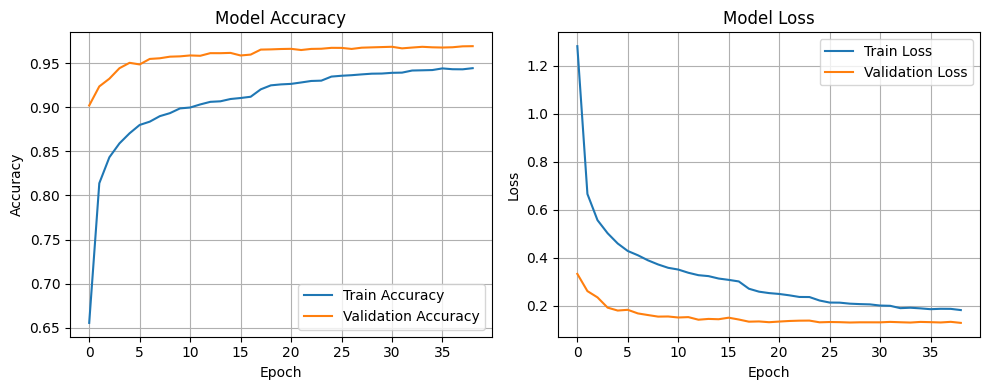

In [6]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()